In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import datetime
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import seaborn as sns
from keras.layers import Dense, BatchNormalization, Dropout, LSTM
from keras.models import Sequential
from keras.utils import to_categorical
from keras.optimizers import Adam
from tensorflow.keras import regularizers
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report, accuracy_score, f1_score
from keras import callbacks

np.random.seed(0)

In [ ]:
data = pd.read_csv("/content/weatherAUS - weatherAUS.csv")
data.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 117676 entries, 0 to 117675
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           117676 non-null  object 
 1   Location       117676 non-null  object 
 2   MinTemp        116359 non-null  float64
 3   MaxTemp        116552 non-null  float64
 4   Rainfall       114747 non-null  float64
 5   Evaporation    65741 non-null   float64
 6   Sunshine       60591 non-null   float64
 7   WindGustDir    107839 non-null  object 
 8   WindGustSpeed  107865 non-null  float64
 9   WindDir9am     108533 non-null  object 
 10  WindDir3pm     113750 non-null  object 
 11  WindSpeed9am   116059 non-null  float64
 12  WindSpeed3pm   114768 non-null  float64
 13  Humidity9am    115246 non-null  float64
 14  Humidity3pm    114144 non-null  float64
 15  Pressure9am    106810 non-null  float64
 16  Pressure3pm    106845 non-null  float64
 17  Cloud9am       72883 non-null

<ipython-input-88-9f925fcff129>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x= data["RainTomorrow"], palette= cols)


<Axes: xlabel='RainTomorrow', ylabel='count'>

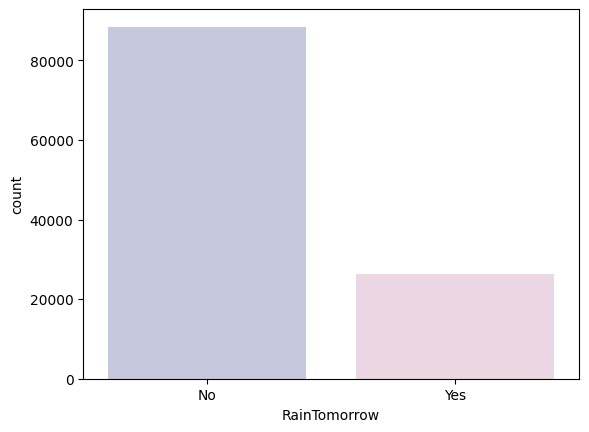

In [ ]:
#first of all let us evaluate the target and find out if our data is imbalanced or not
cols= ["#C2C4E2","#EED4E5"]
sns.countplot(x= data["RainTomorrow"], palette= cols)

/usr/local/lib/python3.10/dist-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/usr/local/lib/python3.10/dist-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


<Axes: >

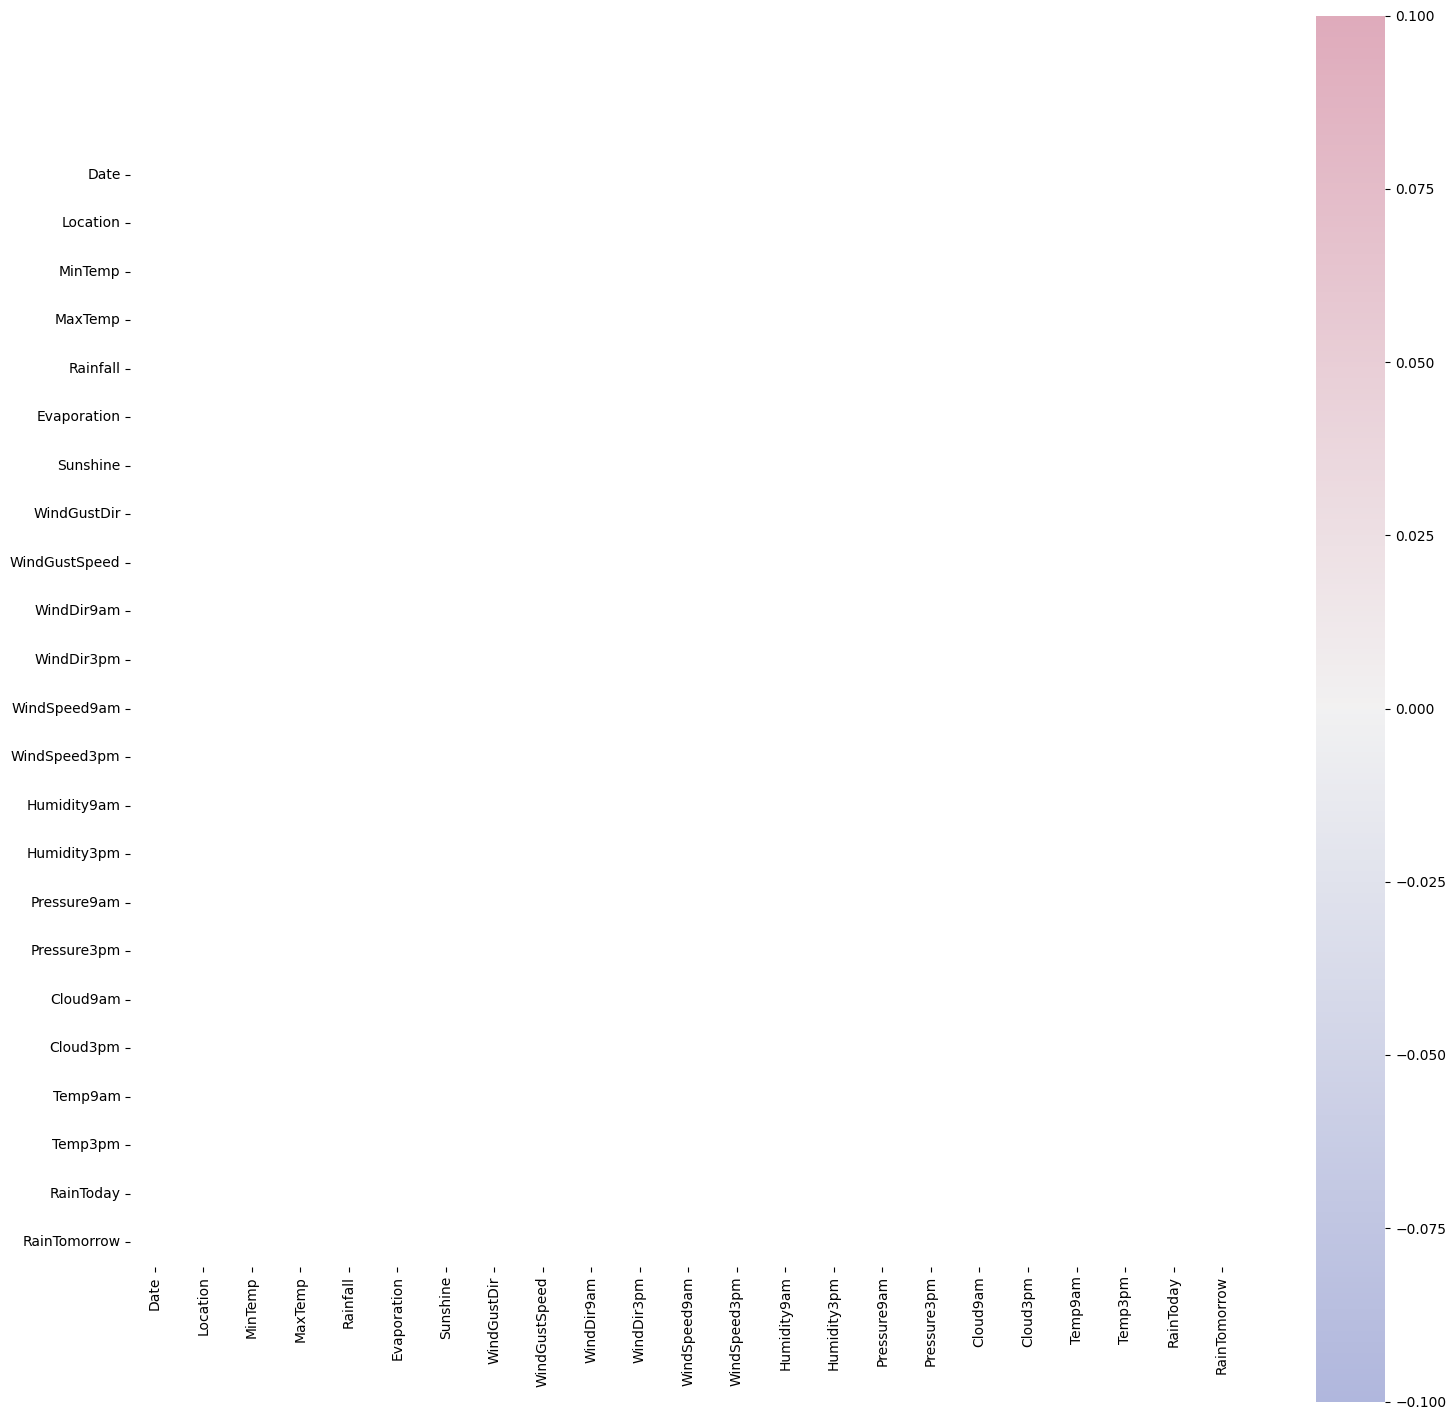

In [ ]:
# Convert non-numeric columns to numeric, if possible
numeric_columns = data.apply(pd.to_numeric, errors='coerce')

# Remove any rows with missing or non-convertible values
numeric_data = numeric_columns.dropna()

# Calculate correlation matrix
corrmat = numeric_data.corr()

# Visualize correlation matrix
cmap = sns.diverging_palette(260,-10,s=50, l=75, n=6, as_cmap=True)
plt.subplots(figsize=(18,18))
sns.heatmap(corrmat,cmap= cmap,annot=True, square=True)


In [ ]:


#Parsing datetime
#exploring the length of date objects
lengths = data["Date"].str.len()
lengths.value_counts()

Date
10    117676
Name: count, dtype: int64

In [ ]:
#There don't seem to be any error in dates so parsing values into datetime
data['Date']= pd.to_datetime(data["Date"])
#Creating a collumn of year
data['year'] = data.Date.dt.year

# function to encode datetime into cyclic parameters.
#As I am planning to use this data in a neural network I prefer the months and days in a cyclic continuous feature.

def encode(data, col, max_val):
    data[col + '_sin'] = np.sin(2 * np.pi * data[col]/max_val)
    data[col + '_cos'] = np.cos(2 * np.pi * data[col]/max_val)
    return data

data['month'] = data.Date.dt.month
data = encode(data, 'month', 12)

data['day'] = data.Date.dt.day
data = encode(data, 'day', 31)

data.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Temp3pm,RainToday,RainTomorrow,year,month,month_sin,month_cos,day,day_sin,day_cos
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,21.8,No,No,2008,12,-2.449294e-16,1.0,1,0.201299,0.979530
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,24.3,No,No,2008,12,-2.449294e-16,1.0,2,0.394356,0.918958
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,23.2,No,No,2008,12,-2.449294e-16,1.0,3,0.571268,0.820763
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,26.5,No,No,2008,12,-2.449294e-16,1.0,4,0.724793,0.688967
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,29.7,No,No,2008,12,-2.449294e-16,1.0,5,0.848644,0.528964


Text(0.5, 0, 'Days In Year')

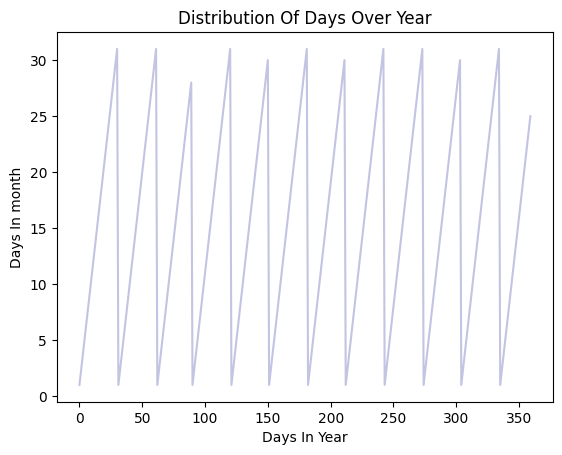

In [ ]:
# roughly a year's span section
section = data[:360]
tm = section["day"].plot(color="#C2C4E2")
tm.set_title("Distribution Of Days Over Year")
tm.set_ylabel("Days In month")
tm.set_xlabel("Days In Year")

Text(0.5, 0, 'Sine Encoded Months')

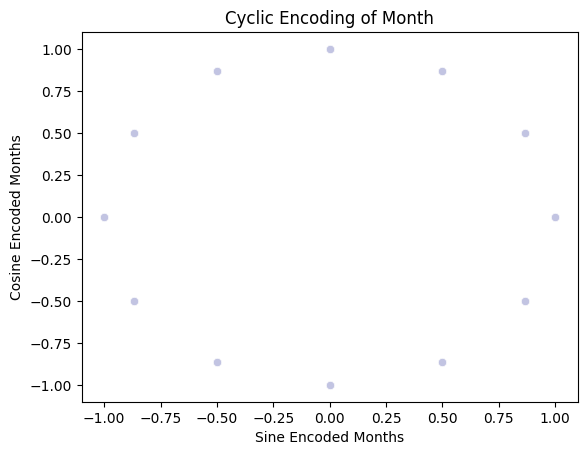

In [ ]:
cyclic_month = sns.scatterplot(x="month_sin",y="month_cos",data=data, color="#C2C4E2")
cyclic_month.set_title("Cyclic Encoding of Month")
cyclic_month.set_ylabel("Cosine Encoded Months")
cyclic_month.set_xlabel("Sine Encoded Months")

Text(0.5, 0, 'Sine Encoded Day')

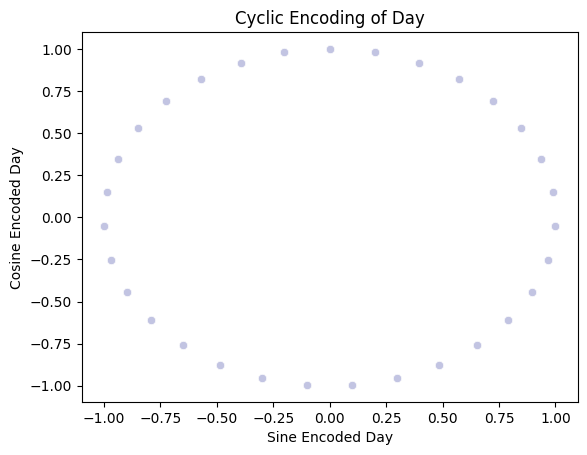

In [ ]:
cyclic_day = sns.scatterplot(x='day_sin',y='day_cos',data=data, color="#C2C4E2")
cyclic_day.set_title("Cyclic Encoding of Day")
cyclic_day.set_ylabel("Cosine Encoded Day")
cyclic_day.set_xlabel("Sine Encoded Day")

In [ ]:
# Get list of categorical variables
s = (data.dtypes == "object")
object_cols = list(s[s].index)

print("Categorical variables:")
print(object_cols)

Categorical variables:
['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday', 'RainTomorrow']


In [ ]:
# Missing values in categorical variables

for i in object_cols:
    print(i, data[i].isnull().sum())

Location 0
WindGustDir 9837
WindDir9am 9143
WindDir3pm 3926
RainToday 2930
RainTomorrow 2932


In [ ]:
# Missing values in categorical variables

for i in object_cols:
    print(i, data[i].isnull().sum())

Location 0
WindGustDir 9837
WindDir9am 9143
WindDir3pm 3926
RainToday 2930
RainTomorrow 2932


In [ ]:
# Get list of neumeric variables
t = (data.dtypes == "float64")
num_cols = list(t[t].index)

print("Neumeric variables:")
print(num_cols)# Get list of neumeric variables
t = (data.dtypes == "float64")
num_cols = list(t[t].index)

print("Neumeric variables:")
print(num_cols)

Neumeric variables:
['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm', 'month_sin', 'month_cos', 'day_sin', 'day_cos']
Neumeric variables:
['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm', 'month_sin', 'month_cos', 'day_sin', 'day_cos']


In [ ]:
# Missing values in numeric variables

for i in num_cols:
    print(i, data[i].isnull().sum())

MinTemp 1317
MaxTemp 1124
Rainfall 2929
Evaporation 51935
Sunshine 57085
WindGustSpeed 9811
WindSpeed9am 1617
WindSpeed3pm 2908
Humidity9am 2430
Humidity3pm 3532
Pressure9am 10866
Pressure3pm 10831
Cloud9am 44793
Cloud3pm 47628
Temp9am 1639
Temp3pm 2801
month_sin 0
month_cos 0
day_sin 0
day_cos 0


In [ ]:
# Filling missing values with median of the column in value

for i in num_cols:
    data[i].fillna(data[i].median(), inplace=True)

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 117676 entries, 0 to 117675
Data columns (total 30 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   Date           117676 non-null  datetime64[ns]
 1   Location       117676 non-null  object        
 2   MinTemp        117676 non-null  float64       
 3   MaxTemp        117676 non-null  float64       
 4   Rainfall       117676 non-null  float64       
 5   Evaporation    117676 non-null  float64       
 6   Sunshine       117676 non-null  float64       
 7   WindGustDir    107839 non-null  object        
 8   WindGustSpeed  117676 non-null  float64       
 9   WindDir9am     108533 non-null  object        
 10  WindDir3pm     113750 non-null  object        
 11  WindSpeed9am   117676 non-null  float64       
 12  WindSpeed3pm   117676 non-null  float64       
 13  Humidity9am    117676 non-null  float64       
 14  Humidity3pm    117676 non-null  float64       
 15  

In [ ]:
# Apply label encoder to each column with categorical data
label_encoder = LabelEncoder()
for i in object_cols:
    data[i] = label_encoder.fit_transform(data[i])

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 117676 entries, 0 to 117675
Data columns (total 30 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   Date           117676 non-null  datetime64[ns]
 1   Location       117676 non-null  int64         
 2   MinTemp        117676 non-null  float64       
 3   MaxTemp        117676 non-null  float64       
 4   Rainfall       117676 non-null  float64       
 5   Evaporation    117676 non-null  float64       
 6   Sunshine       117676 non-null  float64       
 7   WindGustDir    117676 non-null  int64         
 8   WindGustSpeed  117676 non-null  float64       
 9   WindDir9am     117676 non-null  int64         
 10  WindDir3pm     117676 non-null  int64         
 11  WindSpeed9am   117676 non-null  float64       
 12  WindSpeed3pm   117676 non-null  float64       
 13  Humidity9am    117676 non-null  float64       
 14  Humidity3pm    117676 non-null  float64       
 15  

In [ ]:
# Prepairing attributes of scale data

features = data.drop(['RainTomorrow', 'Date','day', 'month'], axis=1) # dropping target and extra columns

target = data['RainTomorrow']

#Set up a standard scaler for the features
col_names = list(features.columns)
s_scaler = preprocessing.StandardScaler()
features = s_scaler.fit_transform(features)
features = pd.DataFrame(features, columns=col_names)

features.describe().T

,count,mean,std,min,25%,50%,75%,max
Location,117676.0,6.955923e-17,1.000004,-1.641703,-0.873987,-0.020969,0.917351,1.685067
MinTemp,117676.0,-4.531011e-16,1.000004,-3.300314,-0.705963,-0.013062,0.744295,3.532013
MaxTemp,117676.0,-2.705081e-17,1.000004,-4.017655,-0.721894,-0.065658,0.678076,3.696760
Rainfall,117676.0,5.023722e-17,1.000004,-0.276186,-0.276186,-0.276186,-0.182244,43.289299
Evaporation,117676.0,-7.197448e-17,1.000004,-1.522313,-0.281621,-0.157552,0.028552,43.452772
Sunshine,117676.0,-2.434573e-16,1.000004,-2.814982,0.072987,0.145186,0.217385,2.419462
WindGustDir,117676.0,3.139826e-17,1.000004,-1.710057,-0.910111,0.089822,0.889768,1.489728
WindGustSpeed,117676.0,-2.067455e-16,1.000004,-2.480328,-0.670028,-0.066594,0.461410,7.174606
WindDir9am,117676.0,-1.468473e-16,1.000004,-1.697935,-0.878247,-0.058558,0.761130,1.580818
WindDir3pm,117676.0,-5.699993e-17,1.000004,-1.892131,-0.845432,-0.008073,0.829286,1.666646


<ipython-input-103-acac0f7a8ea9>:4: UserWarning: 
The palette list has fewer values (5) than needed (26) and will cycle, which may produce an uninterpretable plot.
  sns.boxenplot(data = features,palette = colours)


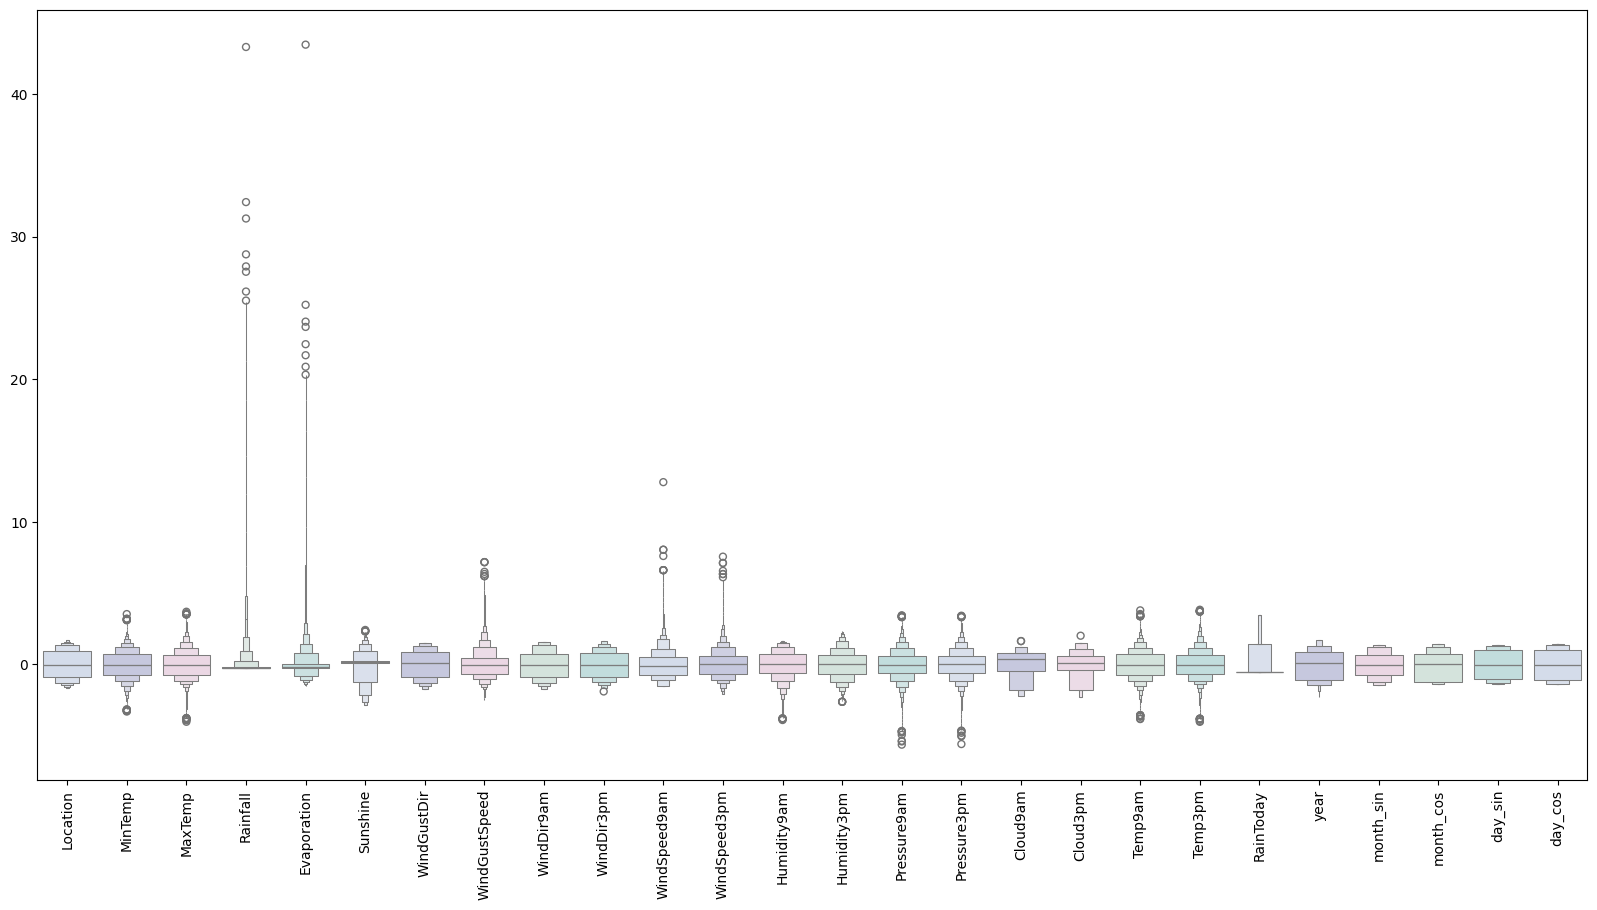

In [ ]:

#looking at the scaled features
colours = ["#D0DBEE", "#C2C4E2", "#EED4E5", "#D1E6DC", "#BDE2E2"]
plt.figure(figsize=(20,10))
sns.boxenplot(data = features,palette = colours)
plt.xticks(rotation=90)
plt.show()

In [ ]:
#full data for
features["RainTomorrow"] = target

#Dropping with outlier

features = features[(features["MinTemp"]<2.3)&(features["MinTemp"]>-2.3)]
features = features[(features["MaxTemp"]<2.3)&(features["MaxTemp"]>-2)]
features = features[(features["Rainfall"]<4.5)]
features = features[(features["Evaporation"]<2.8)]
features = features[(features["Sunshine"]<2.1)]
features = features[(features["WindGustSpeed"]<4)&(features["WindGustSpeed"]>-4)]
features = features[(features["WindSpeed9am"]<4)]
features = features[(features["WindSpeed3pm"]<2.5)]
features = features[(features["Humidity9am"]>-3)]
features = features[(features["Humidity3pm"]>-2.2)]
features = features[(features["Pressure9am"]< 2)&(features["Pressure9am"]>-2.7)]
features = features[(features["Pressure3pm"]< 2)&(features["Pressure3pm"]>-2.7)]
features = features[(features["Cloud9am"]<1.8)]
features = features[(features["Cloud3pm"]<2)]
features = features[(features["Temp9am"]<2.3)&(features["Temp9am"]>-2)]
features = features[(features["Temp3pm"]<2.3)&(features["Temp3pm"]>-2)]


features.shape

(102763, 27)

<ipython-input-105-0b9d7aa52ee8>:4: UserWarning: 
The palette list has fewer values (5) than needed (27) and will cycle, which may produce an uninterpretable plot.
  sns.boxenplot(data = features,palette = colours)


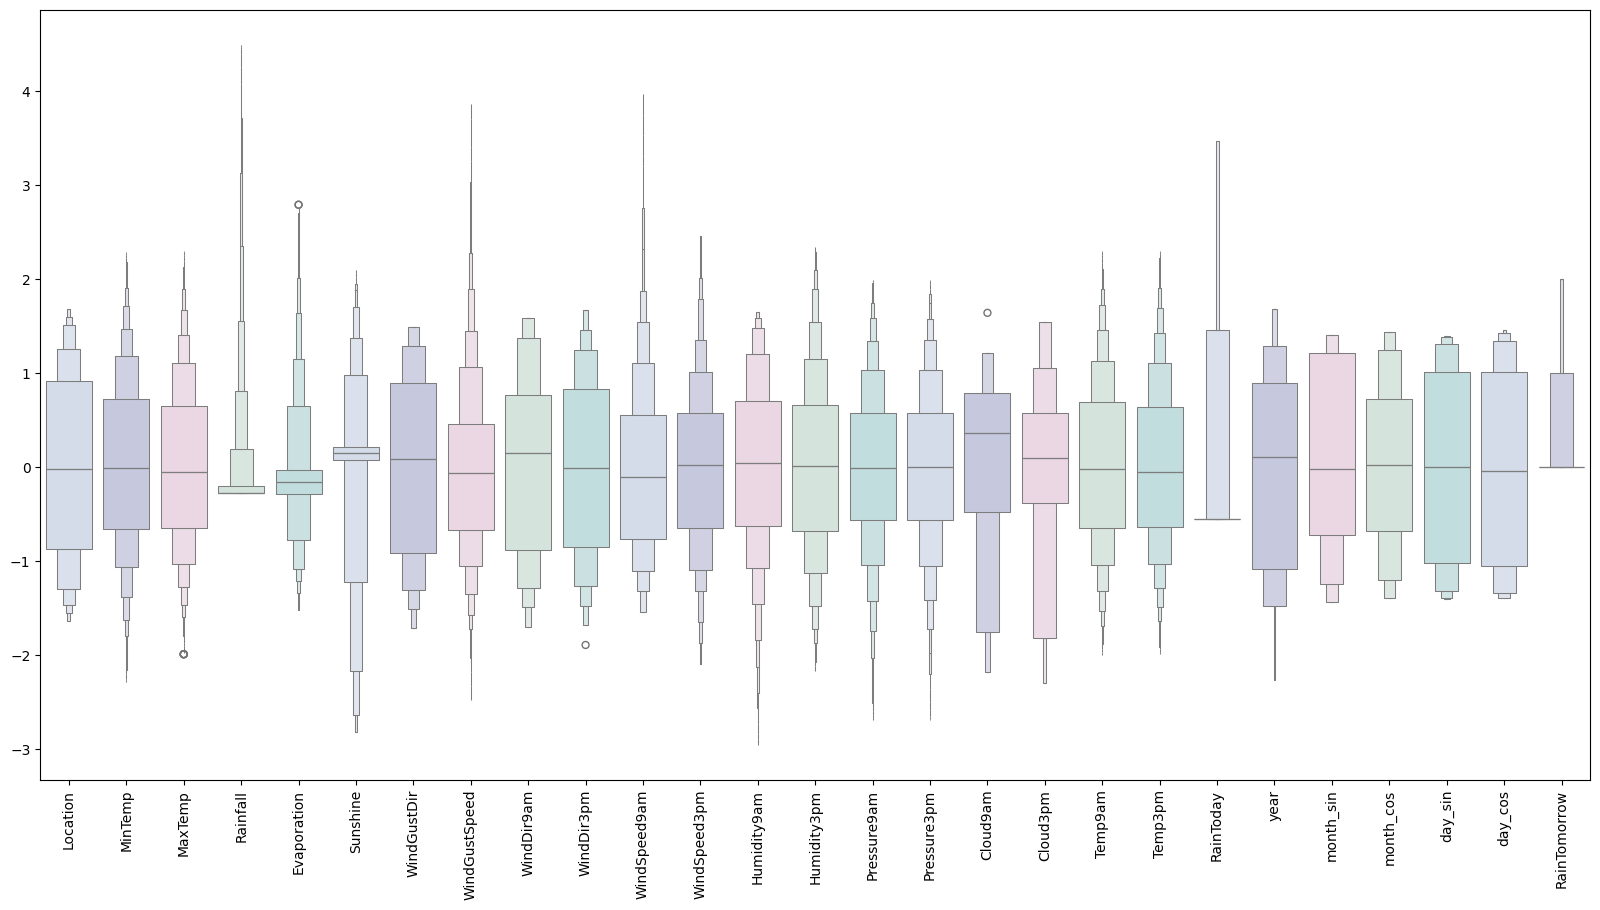

In [ ]:
#looking at the scaled features without outliers

plt.figure(figsize=(20,10))
sns.boxenplot(data = features,palette = colours)
plt.xticks(rotation=90)
plt.show()

In [ ]:
X = features.drop(["RainTomorrow"], axis=1)
y = features["RainTomorrow"]

# Splitting test and training sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

X.shape

(102763, 26)

In [ ]:
#Early stopping
early_stopping = callbacks.EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=20, # how many epochs to wait before stopping
    restore_best_weights=True,
)

# Initialising the NN
model = Sequential()

# layers

model.add(Dense(units = 32, kernel_initializer = 'uniform', activation = 'relu', input_dim = 26))
model.add(Dense(units = 32, kernel_initializer = 'uniform', activation = 'relu'))
model.add(Dense(units = 16, kernel_initializer = 'uniform', activation = 'relu'))
model.add(Dropout(0.25))
model.add(Dense(units = 8, kernel_initializer = 'uniform', activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))

# Compiling the ANN
opt = Adam(learning_rate=0.00009)
model.compile(optimizer = opt, loss = 'binary_crossentropy', metrics = ['accuracy'])

# Train the ANN
history = model.fit(X_train, y_train, batch_size = 32, epochs = 150, callbacks=[early_stopping], validation_split=0.2)

Epoch 1/150
2056/2056 [==============================] - 7s 3ms/step - loss: 0.5263 - accuracy: 0.7647 - val_loss: 0.4436 - val_accuracy: 0.8070
Epoch 2/150
2056/2056 [==============================] - 5s 3ms/step - loss: 0.4593 - accuracy: 0.7901 - val_loss: 0.4226 - val_accuracy: 0.8048
Epoch 3/150
2056/2056 [==============================] - 5s 2ms/step - loss: 0.4438 - accuracy: 0.7922 - val_loss: 0.4078 - val_accuracy: 0.8077
Epoch 4/150
2056/2056 [==============================] - 6s 3ms/step - loss: 0.4341 - accuracy: 0.7934 - val_loss: 0.3979 - val_accuracy: 0.8091
Epoch 5/150
2056/2056 [==============================] - 5s 2ms/step - loss: 0.4293 - accuracy: 0.7952 - val_loss: 0.3922 - val_accuracy: 0.8102
Epoch 6/150
2056/2056 [==============================] - 6s 3ms/step - loss: 0.4224 - accuracy: 0.7963 - val_loss: 0.3883 - val_accuracy: 0.8105
Epoch 7/150
2056/2056 [==============================] - 5s 3ms/step - loss: 0.4204 - accuracy: 0.7953 - val_loss: 0.3825 - val_ac

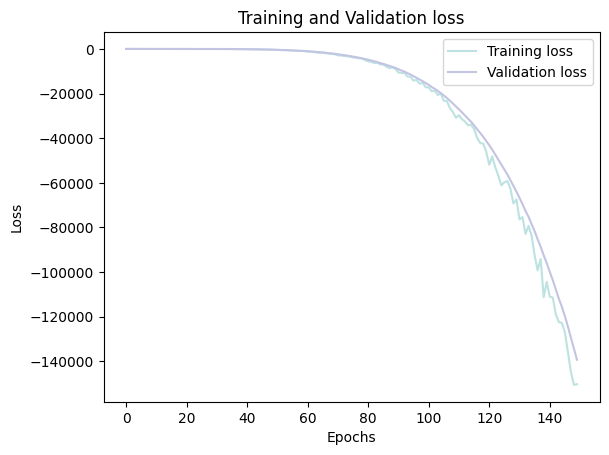

In [ ]:
history_df = pd.DataFrame(history.history)

plt.plot(history_df.loc[:, ['loss']], "#BDE2E2", label='Training loss')
plt.plot(history_df.loc[:, ['val_loss']],"#C2C4E2", label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc="best")

plt.show()

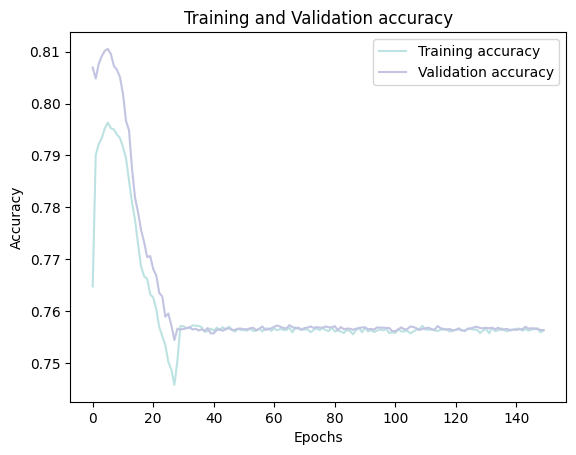

In [ ]:
history_df = pd.DataFrame(history.history)

plt.plot(history_df.loc[:, ['accuracy']], "#BDE2E2", label='Training accuracy')
plt.plot(history_df.loc[:, ['val_accuracy']], "#C2C4E2", label='Validation accuracy')

plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
# Predicting the test set results
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5)

643/643 [==============================] - 1s 1ms/step


<Axes: >

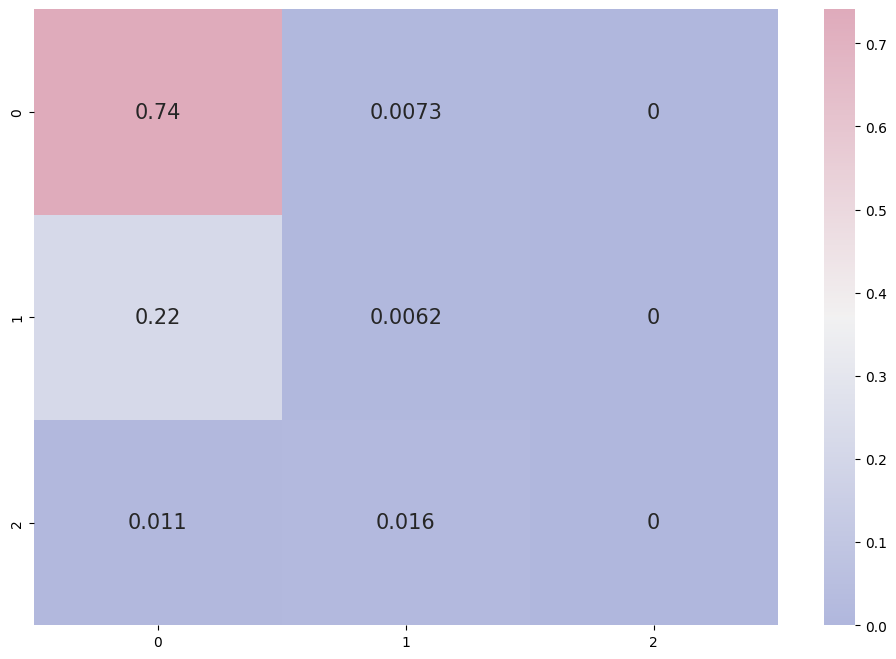

In [ ]:
# confusion matrix
cmap1 = sns.diverging_palette(260,-10,s=50, l=75, n=5, as_cmap=True)
plt.subplots(figsize=(12,8))
cf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(cf_matrix/np.sum(cf_matrix), cmap = cmap1, annot = True, annot_kws = {'size':15})

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.76      0.99      0.86     15379
           1       0.21      0.03      0.05      4612
           2       0.00      0.00      0.00       562

    accuracy                           0.75     20553
   macro avg       0.32      0.34      0.30     20553
weighted avg       0.62      0.75      0.66     20553



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
